In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")

In [4]:
adata = sc.read_10x_mtx("data/3k_pbmc/filtered_gene_bc_matrices/hg19", var_names="gene_symbols", cache=True)
adata.var_names_make_unique()
adata.X

... reading from cache file cache/data-3k_pbmc-filtered_gene_bc_matrices-hg19-matrix.h5ad


<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 2286884 stored elements and shape (2700, 32738)>

In [5]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata.X

filtered out 19024 genes that are detected in less than 3 cells


<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 2282976 stored elements and shape (2700, 13714)>

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795


<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

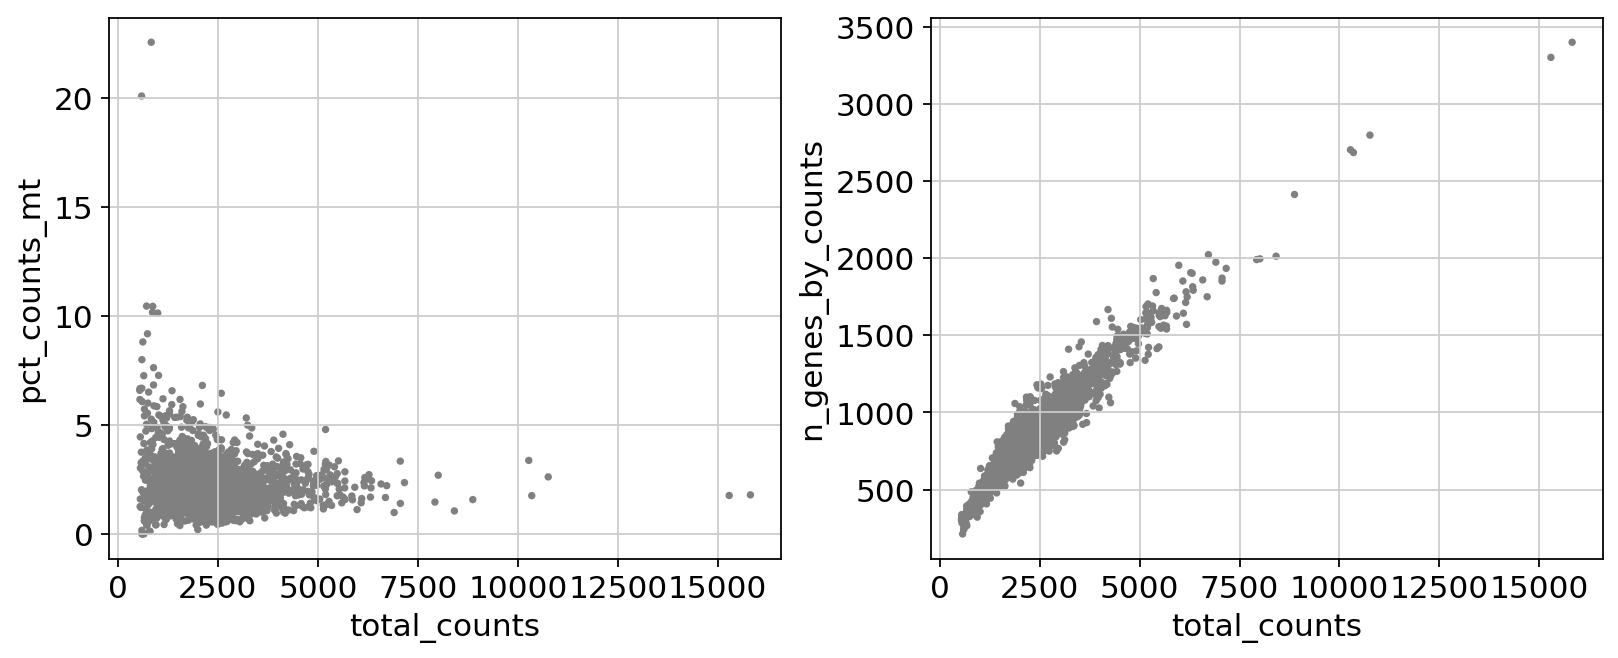

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")

sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1])

In [9]:
upper_lim = np.quantile(adata.obs["n_genes_by_counts"].to_numpy(), 0.97)
lower_lim = np.quantile(adata.obs["n_genes_by_counts"].to_numpy(), 0.03)

In [10]:
adata = adata[
    (adata.obs["n_genes_by_counts"] < upper_lim)
    & (adata.obs["n_genes_by_counts"] > lower_lim)
    & (adata.obs["pct_counts_mt"] < 5),
    :,
].copy()
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 2088949 stored elements and shape (2497, 13714)>

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [ ]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2088949 stored elements and shape (2497, 13714)>

In [19]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:00)


In [26]:
adata.raw = adata.copy()
adata = adata[:, adata.var["highly_variable"]]
adata.X

ArrayView([[-0.03053095, -0.9297094 , -0.05083004, ...,  0.2769674 ,
             0.8086922 ,  0.112326  ],
           [-0.05500655, -1.4463855 , -0.04680893, ..., -0.6207535 ,
            -0.2906094 , -0.4131451 ],
           [-0.05142455,  0.7939772 , -0.03284315, ..., -1.3000147 ,
             0.93748176,  0.24838454],
           ...,
           [-0.02673176, -0.7660483 , -0.04780198, ...,  0.85145944,
            -0.9475652 ,  0.51431453],
           [-0.01983372, -0.62952584, -0.04933323, ...,  1.2216206 ,
            -0.7787416 ,  0.8974505 ],
           [-0.03833443, -0.80137646, -0.03672357, ..., -1.2097507 ,
            -0.65301615,  0.6942765 ]], shape=(2497, 2000), dtype=float32)

computing PCA
    with n_comps=50
    finished (0:00:00)


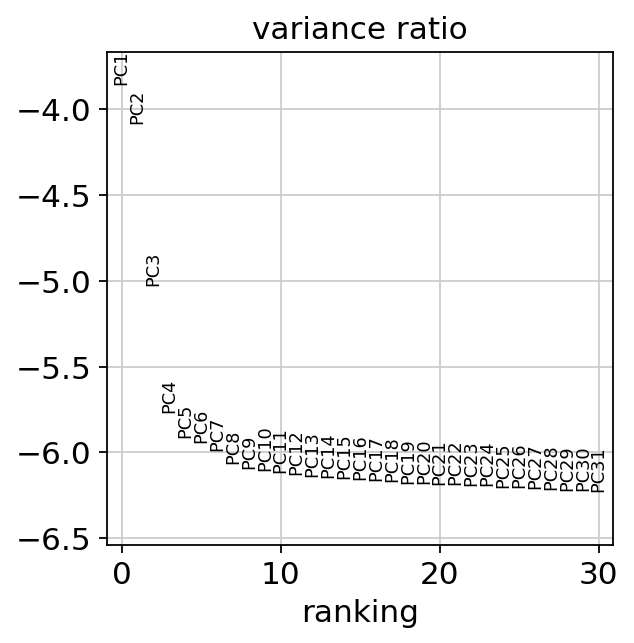

In [29]:
sc.tl.pca(adata, svd_solver='arpack') 
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


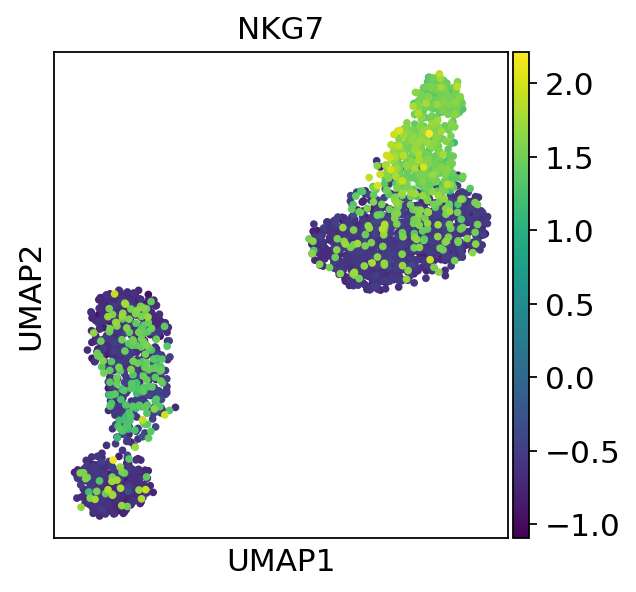

In [39]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["NKG7"])

In [41]:
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


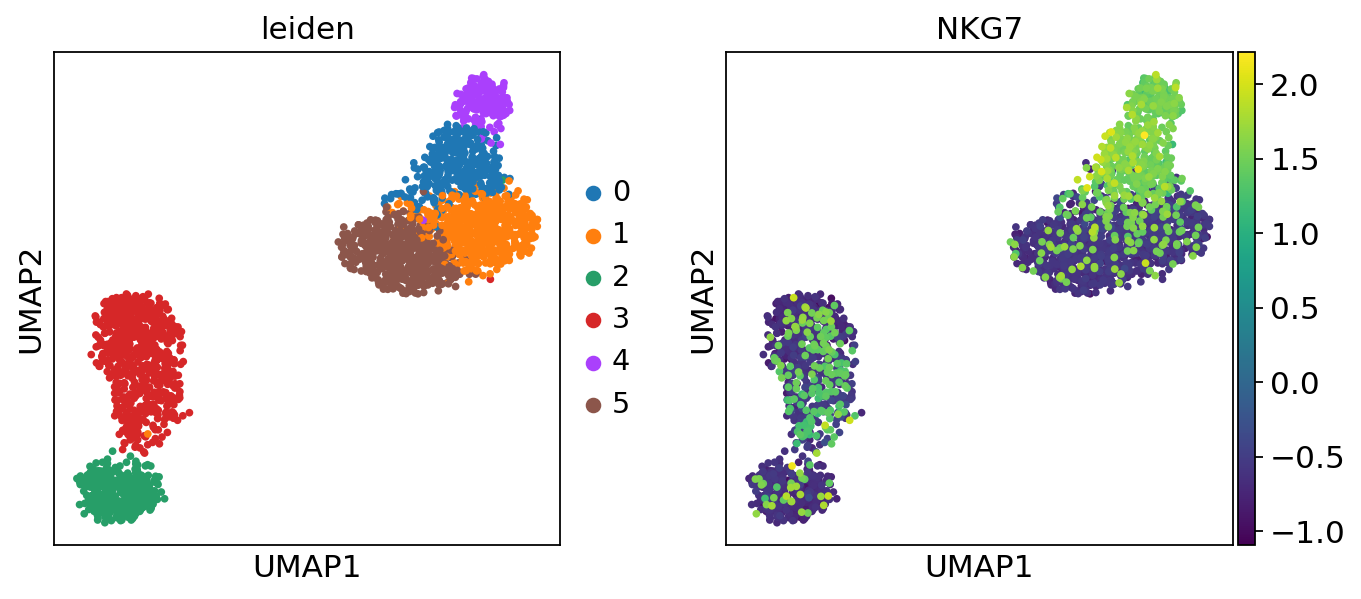

In [43]:
sc.pl.umap(adata, color=["leiden", "NKG7"])